# Set up environment

In [3]:
# Import necessary libraries
import importlib
from multiprocessing import Pool
import os
import random
import sys
from collections import Counter
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
import pandas as pd
import pickle5 as pkl
import scanpy as sc
import seaborn as sns
from scipy.stats import fisher_exact
from scipy.spatial import cKDTree
import skbio
import gseapy
import scipy
from statsmodels import stats
from sklearn.cluster import KMeans
from tqdm import tqdm
from alphashape import alphashape
from scipy.spatial import distance

# Additional imports related to plotting
from scipy.spatial import cKDTree
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import copy
from collections import Counter

# Additional scanpy and tqdm imports
import scanpy as sc
from tqdm import tqdm

# Import custom functions and modules
from slide_tcr_functions import (
    PuckReplicate,
    save_puck,
    load_puck,
    make_adata,
    load_adata,
    pkl_load,
    pkl_dump,
    download_data,
)
from tcr_mapping import tcr_mapping, get_barcode_position, build_6mer_dist, barcode_matching
from plotting_functions import gaussian_heat_plot, plot_cortex_medulla
from perm_test_functions import perm_test_to_final_plot

# Set directory paths
directory = './scratch/publication/'  # Directory with all data
directory_slideseq = './scratch/publication'  # Slide-seq directory

# Set plotting parameters
fontprops = fm.FontProperties(size=18)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams['ps.fonttype'] = 42

pixels_needed = 500 / 0.65

# Reload modules for development purposes
def reload_module(module):
    importlib.reload(module)

# Reload plotting module
reload_module(importlib.import_module('plotting_functions'))

# Reload permutation testing module if needed
# reload_module(importlib.import_module('perm_test_functions'))

# Other settings or configurations can be added here

In [5]:
# Load sample information from Google Sheets
spreadsheet_key = '1wvjq3GM6RGg-uZY8_LhNsjET-XOsPoQ1yH3cnhVWAdk'
xls = pd.ExcelFile(f"https://docs.google.com/spreadsheets/d/{spreadsheet_key}/export?format=xlsx")
master_df = pd.read_excel(xls, 'Slide-TCR-seq', header=1)

# Filter out rows with missing puck names
puck_name_col = 'NovaSeq alignment directory'
master_filt = master_df[~master_df[puck_name_col].isnull()]

# Initialize dictionaries and lists
csv_name_to_puck_name = {}
puck_name_to_timepoint = {}
age_to_ss = {}
puck_to_time = {}
csv_names = []

# Process rows in the master dataframe
for index, row in master_df.iterrows():
    puck_name = row[puck_name_col]
    age = row['Sample Age']
    sample_type = row['Lobe']

    # Skip human samples and non-Mouse_aging analysis types
    if sample_type == 'Human' or row['Analysis Type'] != 'Mouse_aging':
        continue

    # Skip rows with specified Barcodes to TCR csv values
    if row['Barcodes to TCR csv '] in ['in puck folder', 'merge_complete']:
        csv_name = f'{puck_name[11:25]}_B.csv'

        # Populate dictionaries and lists
        csv_name_to_puck_name[csv_name] = puck_name
        csv_names.append(csv_name)
        puck_name_to_timepoint[puck_name] = age

        if age not in age_to_ss:
            age_to_ss[age] = []
        age_to_ss[age].append(row[puck_name_col])
        puck_to_time[puck_name] = age

# Define mappings and orderings
time_to_puck = {puck_to_time[i]: i for i in puck_to_time}
tpt_to_pn = dict(zip(master_df['Sample Age'], master_df['NovaSeq alignment directory']))
tpt_order = ['0 day', '1 day', '2 day', '3 day', '4 day', '5 day', '7 day', '10 day', '13 day', '3wks', '4 wks', '5 wks', '7wks', '9 wks', '13 wks', '15wks', '28wks', '32wks', '48 wks', '68 wks', '90wks']

# Define timepoints, day mappings, and puck names
timepoints = tpt_order

# Load sample information
spreadsheet_key = '1wvjq3GM6RGg-uZY8_LhNsjET-XOsPoQ1yH3cnhVWAdk'
xls = pd.ExcelFile(
    f"https://docs.google.com/spreadsheets/d/{spreadsheet_key}/export?format=xlsx"
)
master_df = pd.read_excel(xls, 'Slide-TCR-seq', header=1)

puck_name_col = 'NovaSeq alignment directory'
master_filt = master_df[~master_df[puck_name_col].isnull()]

csv_name_to_puck_name = {}
puck_name_to_timepoint = {}
age_to_ss = {}
puck_to_time = {}
csv_names = []

for index,row in master_df.iterrows():
    puck_name = row['NovaSeq alignment directory']
    age = row['Sample Age']
    sample_type = row['Lobe']
    
    if sample_type == 'Human':
        continue
    if row['Analysis Type'] != 'Mouse_aging':
        continue
    if row['Barcodes to TCR csv '] in ['in puck folder','merge_complete']: #
        csv_name = f'{puck_name[11:25]}_B.csv'

        csv_name_to_puck_name[csv_name] = puck_name
        csv_names.append(csv_name)
        puck_name_to_timepoint[puck_name] = age
        
        if age not in age_to_ss:
            age_to_ss[age] = []
        age_to_ss[age].append(row[puck_name_col])
        puck_to_time[puck_name] = age

time_to_puck = {puck_to_time[i]: i for i in puck_to_time}

tpt_to_pn = {
    i: j
    for i, j in zip(master_df['Sample Age'],
                    master_df['NovaSeq alignment directory'])
}
tpt_order = [
    '0 day', '1 day', '2 day', '3 day', '4 day', '5 day', '7 day', '10 day',
    '13 day', '3wks', '4 wks', '5 wks', '7wks', '9 wks', '13 wks', '15wks',
    '28wks', '32wks', '48 wks', '68 wks', '90wks'
]


timepoints = [
    '1 day', '2 day', '3 day', '4 day', '5 day', '7 day', '10 day', '13 day',
    '3wks', '4 wks', '5 wks', '7wks', '9 wks', '13 wks', '15wks', '28wks',
    '32wks', '48 wks', '68 wks', '90wks'
]
tpt_to_day = {
    '0 day': 0,
    '1 day': 1,
    '2 day': 2,
    '3 day': 3,
    '4 day': 4,
    '5 day': 5,
    '7 day': 7,
    '10 day': 10,
    '13 day': 13,
    '3wks': 3 * 7,
    '4 wks': 4 * 7,
    '5 wks': 5 * 7,
    '7wks': 7 * 7,
    '9 wks': 9 * 7,
    '13 wks': 13 * 7,
    '15wks': 15 * 7,
    '28wks': 28 * 7,
    '32wks': 32 * 7,
    '48 wks': 48 * 7,
    '68 wks': 68 * 7,
    '90wks': 90 * 7
}

puck_names = ["2023-01-24_Puck_221024_23", # 0 day
                      "2022-11-23_Puck_221024_24", # 0 day
                "2022-11-23_Puck_221024_31", # 1 day
                      "2023-01-16_Puck_221024_27", # 1 day
                      "2022-11-23_Puck_221024_34", # 2 day
                      "2023-01-24_Puck_221024_33", # 2 day
                      "2023-01-24_Puck_221024_36", # 2 day
                      "2022-11-23_Puck_221024_38", # 3 day
                      "2023-01-24_Puck_221024_37", # 3 day
                      "2023-01-24_Puck_221024_39", # 3 day
                      "2023-01-24_Puck_221103_09", # 4 day
                      "2023-01-24_Puck_221103_12", # 4 day
                      "2023-01-24_Puck_221019_08", # 5 day
                      "2023-01-24_Puck_221019_05", # 5 day
                      "2023-01-24_Puck_221019_10", # 7 day
                      "2023-01-24_Puck_221019_14", # 7 day
                      "2022-12-16_Puck_221006_22_trunc", # 10 day
                      "2023-01-24_Puck_221006_23", # 10 day
                      "2022-12-16_Puck_221011_32_trunc", # 13 day
                      "2022-12-16_Puck_221011_33_trunc", # 13 day
                      "2023-01-24_Puck_221118_38", # 3 weeks
                      "2023-01-24_Puck_221118_39", # 3 weeks
                      "2023-01-24_Puck_221103_22", # 4 weeks
                      "2023-01-24_Puck_221118_40", # 4 weeks
                      "2023-01-24_Puck_220930_18", # 5 weeks
                      "2023-01-24_Puck_220930_20", # 5 weeks
                      "2023-01-24_Puck_220930_22", # 5 weeks
                      "2023-01-24_Puck_220930_23", # 7 weeks
                      "2023-01-24_Puck_220930_28", # 7 weeks
                      "2023-01-24_Puck_221011_37", # 9 weeks
                      "2023-01-24_Puck_221011_39", # 9 weeks
                      "2023-01-24_Puck_221011_12", # 13 weeks
                      "2023-01-24_Puck_221011_13", # 13 weeks
                      "2022-11-04_Puck_221006_24", # 15 week
                      "2022-12-16_Puck_221006_26_trunc", # 15 week
                      "2022-11-04_Puck_221006_29", # 28 week
                      "2022-12-16_Puck_221006_35_trunc", # 28 week
                      "2022-11-04_Puck_220930_32", # 32 week
                      "2022-12-16_Puck_220930_29_trunc", # 32 week
                      "2023-01-24_Puck_220930_35", # 32 week
                      "2023-01-24_Puck_221014_37", # 48 week
                      "2023-01-24_Puck_221019_03", # 48 week
                      "2022-12-16_Puck_221011_19_trunc", # 68 week
                      "2022-12-16_Puck_221011_20_trunc", # 68 week
                      "2023-01-24_Puck_221006_32", # 68 week
                      "2022-12-16_Puck_220930_37_trunc", # 90 week
                      "2022-12-16_Puck_220930_38_trunc"] # 90 week
puck_times = [0,0,1,1,2,2,2,3,3,3,4,4,5,5,7,7,10,10,13,13,3*7,3*7,4*7,4*7,5*7,5*7,5*7,
              7*7,7*7,9*7,9*7,13*7,13*7,15*7,15*7,28*7,28*7,32*7,32*7,32*7,48*7,48*7,68*7,68*7,68*7,90*7,90*7]


puck_name_to_days = dict(zip(puck_names, puck_times))

# Define batch mappings
batch_to_tpt = dict(zip(range(len(puck_times)), puck_times))
batch_to_puck_name = dict(zip(range(len(puck_times)), puck_names))

In [6]:
def dilate_cortex_points(bc_cortex, bc_medulla, bc_loc_dict_s1,
                         loc_to_bc_s1, matched_bead_barcodes, locs_cortex, filt_plot=False):
    """
    Dilate cortex points based on the median diversity of nearby points.

    Parameters:
    - bc_cortex: List of cortex barcodes
    - bc_medulla: List of medulla barcodes
    - bc_loc_dict_s1: Dictionary mapping barcodes to locations
    - loc_to_bc_s1: Dictionary mapping locations to barcodes
    - matched_bead_barcodes: List of matched bead barcodes
    - locs_cortex: List of cortex locations
    - filt_plot: Boolean flag to filter the plot

    Returns:
    - Dictionary mapping cortex locations to diluted diversity values
    """

    # Extract cortex locations
    cortex_locs = [bc_loc_dict_s1[bc] for bc in bc_cortex]

    # Extract all locations (cortex + medulla)
    everywhere_locs = [bc_loc_dict_s1[bc] for bc in bc_medulla + bc_cortex]

    # If there are fewer than 2 cortex locations, skip dilation
    if len(cortex_locs) < 2:
        return 'Skip'

    point_tree = cKDTree(cortex_locs)

    # Create a copy of loc_to_diversity for cortex locations
    cort_loc_to_diversity = copy.deepcopy(loc_to_diversity)

    # Iterative dilation process
    num_iter = 0
    while num_iter != 2:  # Limiting the number of iterations for demonstration (can be adjusted)
        num_iter += 1
        print(f"Iteration: {num_iter}")
        print(f"Number of Cortex Locations: {len(cort_loc_to_diversity)}")

        # Find unassigned cortex locations
        unassigned_cortex_locs = [loc for loc in cortex_locs if loc not in cort_loc_to_diversity]

        # Dilate unassigned cortex locations
        for loc in unassigned_cortex_locs:
            # Find points within a radius of 20 units
            idx_closeby_points = point_tree.query_ball_point(loc, r=20 / 0.65)
            nearest_points = [cortex_locs[idx] for idx in idx_closeby_points]

            # Extract diversity values for nearby points
            div = [cort_loc_to_diversity[i] for i in nearest_points if i in cort_loc_to_diversity]

            # If there are diversity values, assign the median to the current location
            if len(div) > 0:
                cort_loc_to_diversity[loc] = np.median(div)

        # Make a plot
        plot_dilated_cortex(cort_loc_to_diversity, everywhere_locs, cortex_locs, locs_cortex, filt_plot)

    print('Hotspot dilation complete')
    return cort_loc_to_diversity


def plot_dilated_cortex(cort_loc_to_diversity, everywhere_locs, cortex_locs, locs_cortex, filt_plot):
    """
    Plot the dilated cortex.

    Parameters:
    - cort_loc_to_diversity: Dictionary mapping cortex locations to diluted diversity values
    - everywhere_locs: List of all locations (cortex + medulla)
    - cortex_locs: List of cortex locations
    - locs_cortex: List of cortex locations for filtering
    - filt_plot: Boolean flag to filter the plot
    """
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot everywhere locations in gray
    x2, y2 = zip(*everywhere_locs)
    plt.scatter(x2, y2, c='gray', s=1, alpha=0.05)  # Everywhere

    # Plot cortex locations in gray with higher alpha
    x2, y2 = zip(*cortex_locs)
    plt.scatter(x2, y2, c='gray', s=1, alpha=0.2)

    # Plot diluted cortex locations
    if filt_plot:
        locs_filt, c = zip(*[(loc, c) for loc, c in zip(list(cort_loc_to_diversity.keys()), list(cort_loc_to_diversity.values())) if loc in locs_cortex])
        x, y = zip(*locs_filt)
    else:
        x, y = zip(*list(cort_loc_to_diversity.keys()))
        c = list(cort_loc_to_diversity.values())

    # Scatter plot with color map
    p = plt.scatter(x, y, c=c, s=1, cmap='inferno', vmin=3.3, vmax=5.4)

    # Additional plot settings
    plt.axis('off')
    plt.xlim([0, 5000])
    plt.ylim([0, 5000])
    cb_ax = fig.add_axes([.91, .124, .04, .754])
    fig.colorbar(p, orientation='vertical', cax=cb_ax)
    fontprops = fm.FontProperties(size=18)
    scalebar = AnchoredSizeBar(
        ax.transData,
        pixels_needed,
        "",
        "lower right",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=1,
        fontproperties=fontprops,
    )
    ax.add_artist(scalebar)

    plt.show()


# Example usage:
# dilate_cortex_points(bc_cortex, bc_medulla, bc_loc_dict_s1, loc_to_bc_s1, matched_bead_barcodes, locs_cortex, filt_plot=False)

def plot_gene_expression_on_pucks(pucks_to_plot, genes_to_plot):
    """
    Plot gene expression on specified pucks for selected genes.

    Parameters:
    - pucks_to_plot: List of puck names to be plotted
    - genes_to_plot: List of gene names to be plotted

    Returns:
    - None
    """
    vmax_calc = {i: [] for i in genes_to_plot}
    vmax_for_genes = {i: 0 for i in genes_to_plot}  # identify 90th percentile
    vmin_calc = {i: [] for i in genes_to_plot}
    vmin_for_genes = {i: 0 for i in genes_to_plot}  # identify 90th percentile
    all_x_agg = {}
    all_y_agg = {}
    all_adata_filt = {}
    all_total_counts = {}

    # Calculate vmax values
    for pn in tqdm(pucks_to_plot):
        if pn not in loaded_pucks:
            with open(f'{directory}{pn}_raw.h5ad', "rb") as handle:
                adata = sc.read_h5ad(handle)
            loaded_pucks[pn] = adata
        else:
            adata = loaded_pucks[pn]
        all_x = adata.obs['x']
        all_y = adata.obs['y']

        all_x_agg[pn] = all_x
        all_y_agg[pn] = all_y

        adata = adata[adata.obs['cortex_medulla'].isin(['cortex', 'medulla'])]  # clean up areas outside tissue
        all_adata_filt[pn] = adata

        total_counts_per_cell = np.sum(adata.X, axis=1)
        all_total_counts[pn] = total_counts_per_cell

        for gene_name in genes_to_plot:
            gene_idx = list(adata.var.index).index(gene_name)
            gene_filt = adata.X[:, gene_idx]
            gene_filt = [i / x * 10000 for i, x in zip(gene_filt, total_counts_per_cell)]

            bc_indices = [index for index, val in enumerate(gene_filt) if val > 0]
            gene_filt = [val for index, val in enumerate(gene_filt) if val > 0]

            vmax_calc[gene_name] = vmax_calc[gene_name] + gene_filt
            vmin_calc[gene_name] = vmin_calc[gene_name] + gene_filt

    # Set percentile for plotting visualization
    vmax_for_genes = {i: np.percentile(vmax_calc[i], 90) for i in vmax_calc}  # Make cutoff 90th percentile of max
    vmin_for_genes = {i: np.percentile(vmin_calc[i], 10) for i in vmin_calc}  # Make cutoff 90th percentile of max

    # Create plots
    plt.figure(figsize=(len(genes_to_plot) * 4, len(pucks_to_plot) * 4))
    plt.subplots_adjust(hspace=0.5)
    plt_cter = 1

    # Make plots
    for pn in tqdm(pucks_to_plot):
        all_x = all_x_agg[pn]
        all_y = all_y_agg[pn]

        adata = all_adata_filt[pn]  # clean up areas outside tissue
        total_counts_per_cell = all_total_counts[pn]

        for gene_name in genes_to_plot:
            ax = plt.subplot(len(pucks_to_plot), len(genes_to_plot), plt_cter)
            ax.scatter(all_x, all_y, c='black', s=1)  # Plot locations in black

            gene_idx = list(adata.var.index).index(gene_name)
            gene_filt = adata.X[:, gene_idx]
            gene_filt = [i / x * 10000 for i, x in zip(gene_filt, total_counts_per_cell)]
            all_len = len(gene_filt)

            bc_indices = [index for index, val in enumerate(gene_filt) if val > 0]
            gene_filt = [val for index, val in enumerate(gene_filt) if val > 0]
            x = [adata.obs['x'][i] for i in bc_indices]
            y = [adata.obs['y'][i] for i in bc_indices]

            vmax_calc[gene_name] = vmax_calc[gene_name] + gene_filt

            vmin = vmin_for_genes[gene_name]
            vmax = vmax_for_genes[gene_name]
            thisfig = ax.scatter(x, y, c=gene_filt, s=1, cmap='viridis', vmin=vmin, vmax=vmax)
            fig.colorbar(thisfig)
            ax.set_title(f"{gene_name} {len(gene_filt)/all_len:.2%}")

            plt_cter += 1
            ax.set_xlim([0, 5000])
            ax.set_ylim([0, 5000])
            ax.set_aspect('equal')

            scalebar = AnchoredSizeBar(
                ax.transData,
                pixels_needed,
                "",
                "lower right",
                pad=0.1,
                color="black",
                frameon=False,
                size_vertical=1,
                fontproperties=fontprops,
            )
            ax.add_artist(scalebar)

    plt.show()

# Example usage:
# plot_gene_expression_on_pucks(pucks_to_plot, genes_to_plot)


def rolling_average(x, y, title):
    # Create a scatter plot of the data points
    fig, ax = plt.subplots() 
    plt.scatter(x, y)
    
    # Calculate the slope (m) and intercept (b) of the line
    m, b = np.polyfit(np.log10(x), y, 1)

    # Generate x values for the line of best fit
    x_fit = np.linspace(min(x), max(x), 10)

    # Calculate corresponding y values using the equation of the line
    y_fit = m * np.log10(x_fit) + b
    
    # Plot the line of best fit
    plt.plot(x_fit, y_fit, color='red', label=f'Line of Best Fit: y = {m:.2f}x + {b:.2f}')

    # Calculate and display Pearson correlation coefficient and p-value
    stat, pval = scipy.stats.pearsonr(np.log10(timepoints), y)
    plt.title(f'R = {round(stat,2)} | p = {round(pval,5)}')
    
    # Set x-axis scale to logarithmic
    ax.set_xscale('log', base=10)
    ax.set_xticks([20, 100, 500])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    
    # Save the plot as a PDF file
    plt.savefig(f'{title}_sc_proportion.pdf')

def find_nearest_point_distance(target_point, list_of_points):
    """
    Find the point in a list of points closest to a target point.

    Parameters:
    - target_point (tuple): The target point in the form of (x, y).
    - list_of_points (list of tuples): List of points in the form of [(x1, y1), (x2, y2), ...].

    Returns:
    - nearest_point (tuple): The point in the list closest to the target point.
    - distance_to_nearest (float): The distance between the target point and the nearest point.
    """
    target_point = np.array(target_point)
    
    # Calculate Euclidean distances between the target point and all points in the list
    distances = distance.cdist(target_point, list_of_points, metric='euclidean')
    
    # Find the index of the nearest point
    index_of_nearest = np.argmin(distances)

    # Get the nearest point and its distance to the target point
    nearest_point = list_of_points[index_of_nearest]
    distance_to_nearest = distances[0, index_of_nearest]

    return nearest_point, distance_to_nearest

def calculate_distance_to_boundary(cluster_points, points_of_interest, alpha=0.03, show_plot = False):
    """
    Calculate the distance from each point in a cluster to the boundary of the alpha shape.

    Parameters:
    - cluster_points (list of tuples): List of (x, y) coordinates for the points in the cluster.
    - alpha (float): Alpha parameter for alpha shape. Smaller alpha values will create more detailed shapes.

    Returns:
    - distances (list of floats): List of distances from each point to the boundary.
    - boundary (list of tuples): List of (x, y) coordinates representing the boundary of the alpha shape.
    """

    # Convert the list of tuples to a numpy array for compatibility with alphashape
    points = np.array(cluster_points)
    x,y = zip(*points)
    # Create the alpha shape
    alpha_shape = alphashape(points, alpha=alpha)

    shape_x, shape_y = alpha_shape.exterior.coords.xy
    
    boundary = list(zip(shape_x,shape_y))
    if show_plot:
        plt.figure(figsize=(3,3))
        plt.plot(x, y, 'o', color='black', markersize=6)
        plt.plot(shape_x, shape_y, 'o', color='red', markersize=4)
        plt.xlim([0,5000])
        plt.ylim([0,5000])
        plt.show()
    
    # Calculate the distance from each point to the boundary
    distances = [find_nearest_point_distance([point], boundary) for point in points_of_interest]

    return alpha_shape, distances, boundary



# Figure 1

## Figure 1B and S1B - Plotting cells in pucks 

In [16]:
# Representative young and aged plots
young_aged = ["2023-01-24_Puck_221024_39", '2022-12-16_Puck_220930_38_trunc']
# Example: 39, 3 days or 38, 90 weeks

# For B cell plots in supp
representative_puck_names = [
    "2023-01-24_Puck_221024_39",
    '2023-01-24_Puck_220930_35',
    '2023-01-24_Puck_221014_37',
    '2023-01-24_Puck_221006_32',
    '2022-12-16_Puck_220930_38_trunc'
]

In [17]:
# Load all rctd
load = True
reload_and_clear = True  # Set to False if only adding more pucks
puck_names_use = young_aged + representative_puck_names

if reload_and_clear:
    adata_all = {}
    rctd_all = {}

if load:
    for slideseq_name in tqdm(puck_names_use):
        if slideseq_name not in adata_all:
            adata = sc.read(f'{directory}{slideseq_name}_cortex_medulla_xy.h5ad')
            rctd_results = pd.read_csv(f'{directory}{slideseq_name}_RCTD_results.csv')
            adata_all[slideseq_name] = adata
            rctd_all[slideseq_name] = rctd_results
        else:
            adata = adata_all[slideseq_name]
            rctd_results = rctd_all[slideseq_name]


100%|██████████| 7/7 [00:43<00:00,  6.24s/it]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


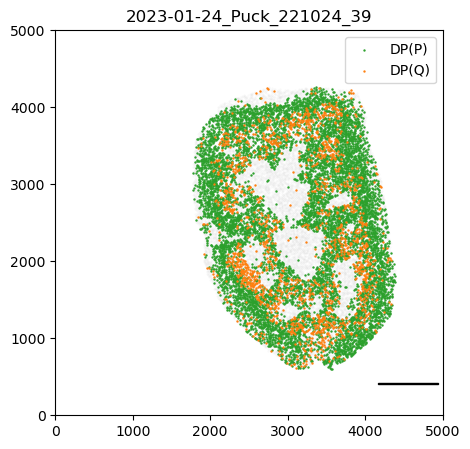

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

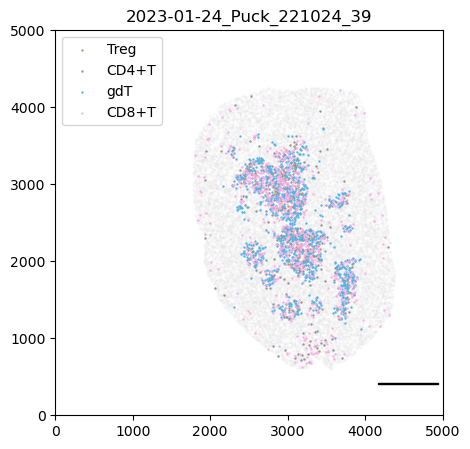

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


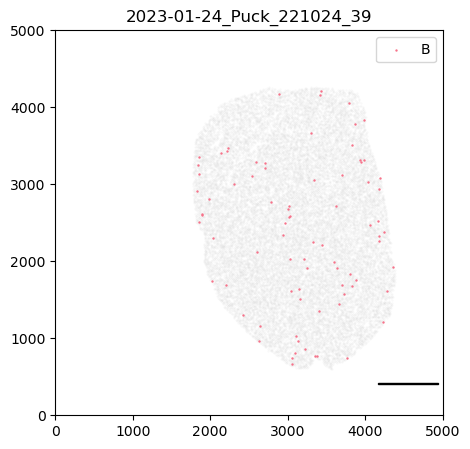

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


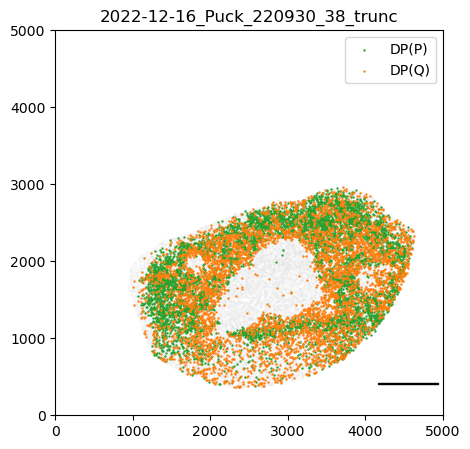

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

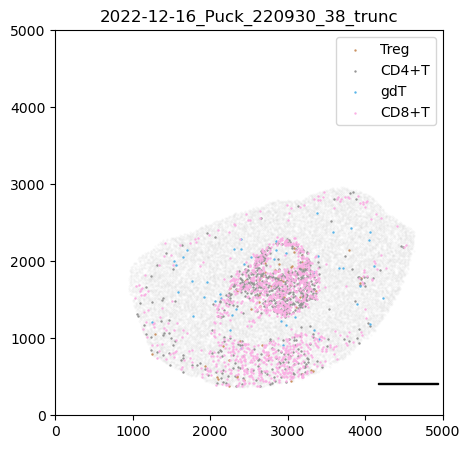

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


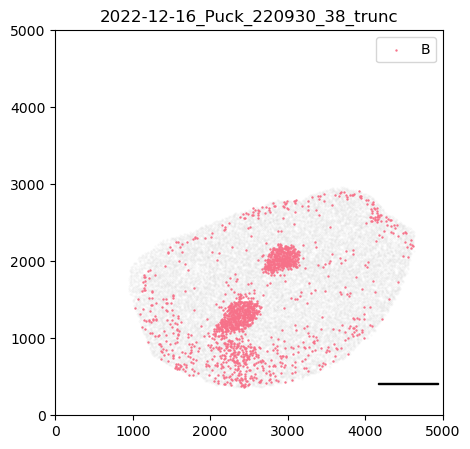

In [18]:
# Plot cell_types
def plot_cell_types(adata, rctd_results, cell_type_list, title, colors=None, point_size=0.5):
    """
    Plot cell types on a spatial map.

    Parameters:
    - adata: AnnData object containing spatial information.
    - rctd_results: DataFrame containing RCTD results.
    - cell_type_list: List of cell types to plot.
    - title: Title of the plot.
    - colors: List of colors for each cell type.
    - point_size: Size of the plotted points.
    """
    if colors is None:
        colors = sns.color_palette('husl', len(cell_type_list))

    fig, ax = plt.subplots(figsize=(5, 5))
    plt.xlim([0, 5000])
    plt.ylim([0, 5000])

    loc_list = zip(adata.obs.x, adata.obs.y)
    bc_to_loc = {i: j for i, j in zip(adata.obs.index, loc_list)}

    # Filter data for cortex and medulla regions
    adata_filt = adata[adata.obs.cortex_medulla.isin(['cortex', 'medulla'])]
    all_x, all_y = [adata_filt.obs.x, adata_filt.obs.y]
    plt.scatter(all_x, all_y, alpha=0.025, color='gray', s=1)

    # Plot each cell type
    for idx in range(len(cell_type_list)):
        ct = cell_type_list[idx]
        bcs = rctd_results[rctd_results['first_type'] == ct]['Unnamed: 0']
        bcs = [i[:-2] + '-1' for i in bcs if i[:-2] + '-1' in adata_filt.obs.index]
        locs = [bc_to_loc[i] for i in bcs]
        x, y = zip(*locs)
        plt.scatter(x, y, s=point_size, c=colors[idx], label=ct)

    # Add scale bar
    scalebar = AnchoredSizeBar(
        ax.transData,
        pixels_needed,
        "",
        "lower right",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=1,
        fontproperties=fontprops,
    )
    ax.add_artist(scalebar)

    plt.title(title)
    plt.legend()
    plt.show()

# Iterate over young_aged puck names and plot cell types
for slideseq_name in young_aged:
    adata = adata_all[slideseq_name]
    rctd_results = rctd_all[slideseq_name]

    # Plot double positive cell types
    plot_cell_types(adata, rctd_results, cell_type_list=['DP(P)', 'DP(Q)'], title=slideseq_name,
                    colors=sns.color_palette()[1:3][::-1])

    # Plot T cell types
    plot_cell_types(adata, rctd_results, cell_type_list=['Treg', 'CD4+T', 'gdT', 'CD8+T'], title=slideseq_name,
                    colors=[sns.color_palette('colorblind', 10)[5], sns.color_palette('colorblind', 10)[7],
                            sns.color_palette('colorblind', 10)[9], sns.color_palette('colorblind', 10)[6]])

    # Plot B cells
    plot_cell_types(adata, rctd_results, cell_type_list=['B'], title=slideseq_name)


  0%|          | 0/5 [00:00<?, ?it/s]*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


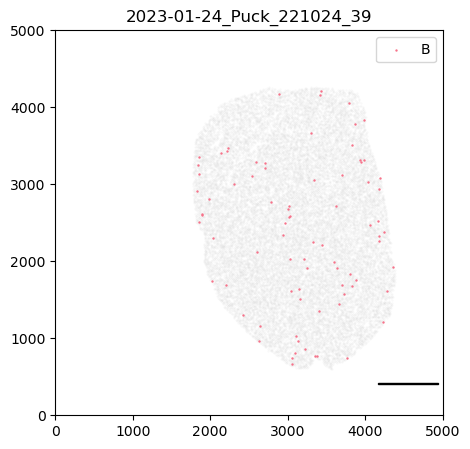

 20%|██        | 1/5 [00:02<00:09,  2.31s/it]

2023-01-24_Puck_221024_39


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


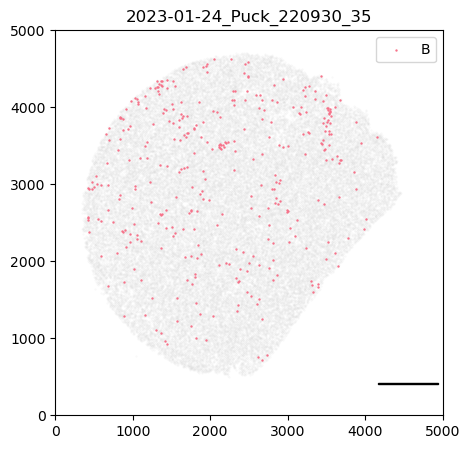

 40%|████      | 2/5 [00:07<00:12,  4.21s/it]

2023-01-24_Puck_220930_35


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


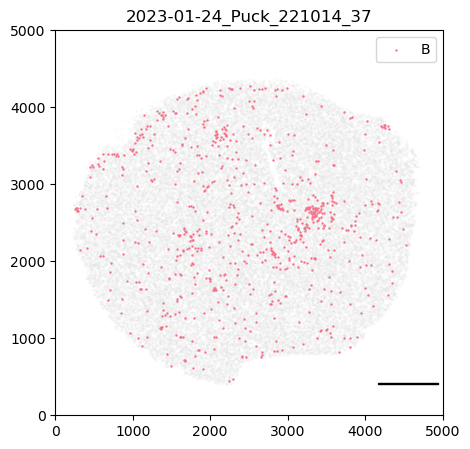

 60%|██████    | 3/5 [00:17<00:13,  6.64s/it]

2023-01-24_Puck_221014_37


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


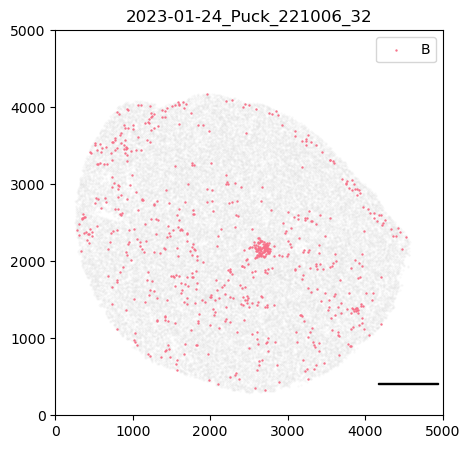

 80%|████████  | 4/5 [00:21<00:05,  5.77s/it]

2023-01-24_Puck_221006_32


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


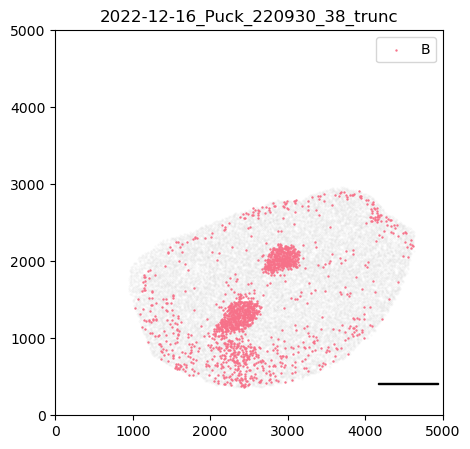

100%|██████████| 5/5 [00:24<00:00,  4.89s/it]

2022-12-16_Puck_220930_38_trunc


In [20]:
# Iterate over representative B cell puck names and plot cell types in supplemental
for slideseq_name in tqdm(representative_puck_names):
    # Check if data is already loaded, if not, load and store it
    if slideseq_name not in adata_all:
        adata = sc.read(f'{directory}{slideseq_name}_cortex_medulla_xy.h5ad')
        rctd_results = pd.read_csv(f'{directory}{slideseq_name}_RCTD_results.csv')
        adata_all[slideseq_name] = adata
        rctd_all[slideseq_name] = rctd_results
    else:
        adata = adata_all[slideseq_name]
        rctd_results = rctd_all[slideseq_name]

    # Plot B cell types
    plot_cell_types(adata, rctd_results, cell_type_list=['B'], title=slideseq_name)
    print(slideseq_name)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


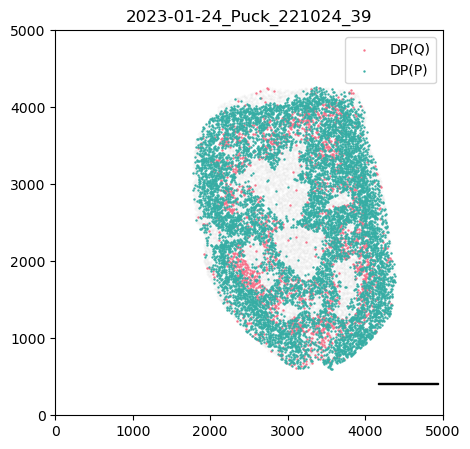

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


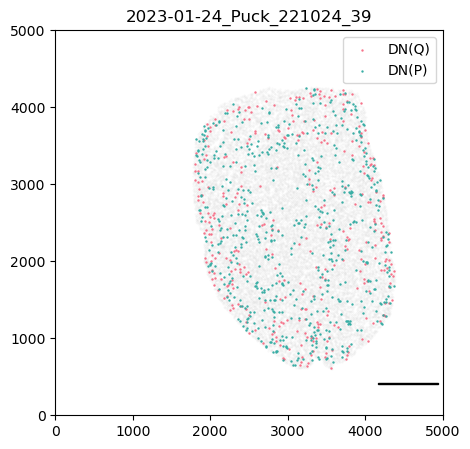

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


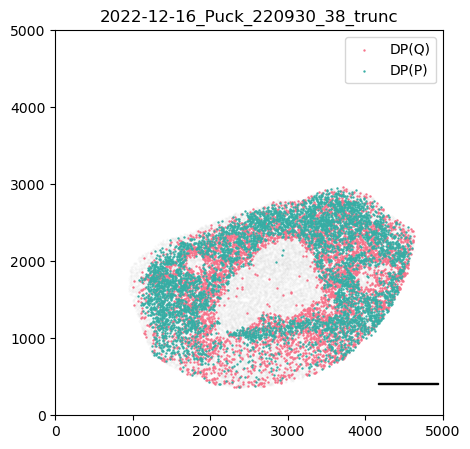

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


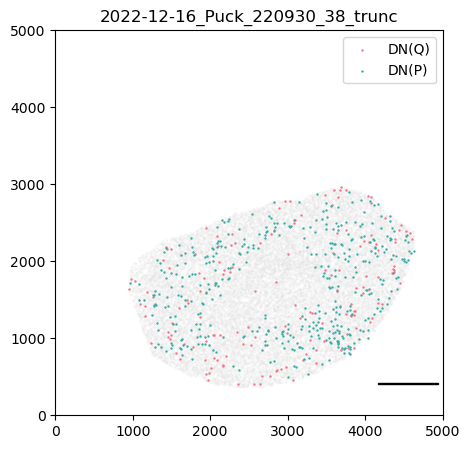

In [21]:
# Iterate over the young and aged puck names
for slideseq_name in young_aged:
    # Retrieve data from pre-loaded dictionaries
    adata = adata_all[slideseq_name]
    rctd_results = rctd_all[slideseq_name]
    
    # Plot double positive cell types
    plot_cell_types(adata, rctd_results, cell_type_list=['DP(Q)', 'DP(P)'],
                    title=slideseq_name)
    
    # Plot double negative cell types
    plot_cell_types(adata, rctd_results, cell_type_list=['DN(Q)', 'DN(P)'],
                    title=slideseq_name)


## S1G

100%|██████████| 47/47 [00:05<00:00,  8.22it/s]


0.9395414142857144


Ttest_indResult(statistic=-9.985120228340072, pvalue=1.0943557852568334e-13)

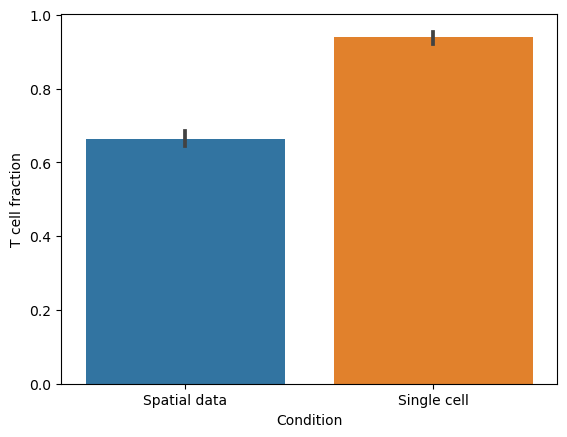

In [22]:
# Load spatial data
with open(f'{directory}thymuscombined_xy.h5ad', "rb") as handle:
    adata = sc.read_h5ad(handle)

# Count fraction of cell types that are T cells
conditions = []
fraction_t_cells = []

# Iterate over batches in the spatial data
for batch in tqdm(set(adata.obs.Batch)):
    adata_use = adata[adata.obs.Batch == batch]
    t_cell_types = ['CD4+T', 'CD8+T', 'DN(Q)', 'DP(P)', 'DP(Q)', 'DN(P)', 'alpha_beta_T(entry)', 'gdT', 'Treg']
    conditions.append('Spatial data')
    fraction_t_cells.append(len(adata_use[adata_use.obs['Cell_type'].isin(t_cell_types)]) / len(adata_use))

# Define single-cell fractions from R
single_cell_frac = [0.9615505, 0.9540805, 0.9503862, 0.9546377, 0.9452543, 0.9210848, 0.8897959]

# Append single-cell fractions to conditions and fraction_t_cells lists
print(np.average(single_cell_frac))
for samp in single_cell_frac:
    conditions.append('Single cell')
    fraction_t_cells.append(samp)

# Create a DataFrame for plotting
plot_df = pd.DataFrame.from_dict({'Condition': conditions, 'T cell fraction': fraction_t_cells})

# Plot barplot comparing spatial data and single-cell fractions
sns.barplot(plot_df, x='Condition', y='T cell fraction')
plt.savefig('Spatial vs single-cell.pdf')

# Perform t-test between spatial data and single-cell conditions
scipy.stats.ttest_ind(
    plot_df[plot_df.Condition == 'Spatial data']['T cell fraction'],
    plot_df[plot_df.Condition == 'Single cell']['T cell fraction']
)

## S1F

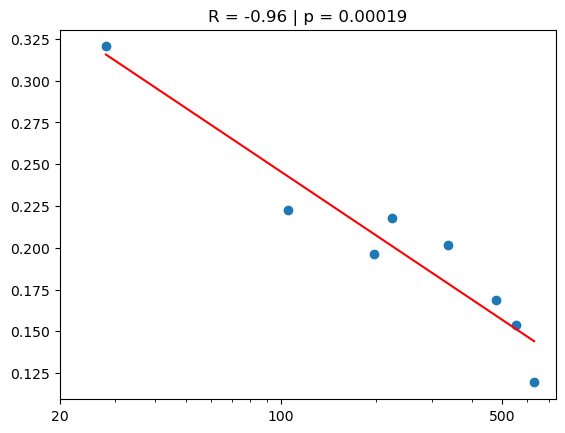

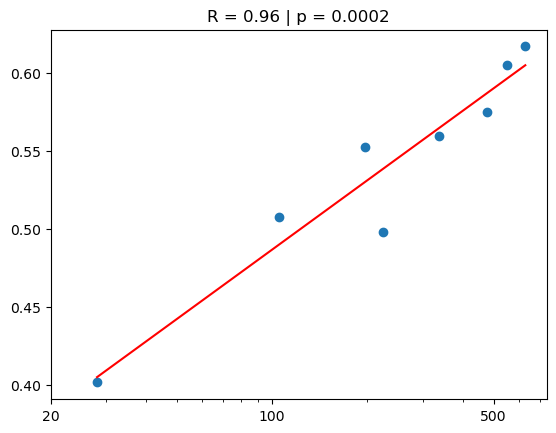

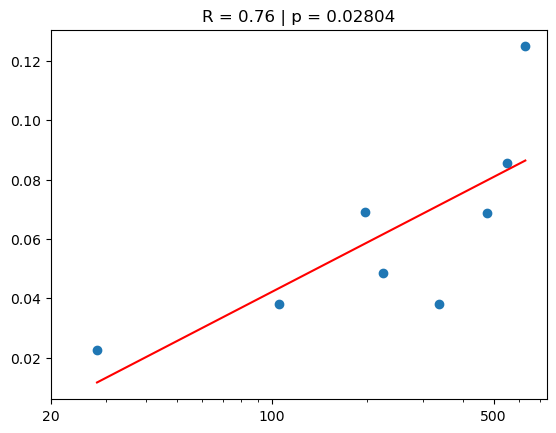

In [25]:
# Define timepoints and cell type proportions
timepoints = [4*7, 15*7, 28*7, 32*7, 48*7, 68*7, 79*7, 90*7]
cd4 = [0.3204372, 0.2227706, 0.1965469, 0.217897, 0.2016639, 0.1687399, 0.1539831, 0.1193692]
cd8 = [0.4014573, 0.507747,  0.5524939, 0.4978118, 0.5599002, 0.5751082, 0.6056409, 0.6172392]
nkt = [0.02255378, 0.03810398, 0.06914894, 0.04860071, 0.03801997, 0.06875338, 0.08561415, 0.1248074]

# Call the function for each cell type
rolling_average(timepoints, cd4, 'cd4')
rolling_average(timepoints, cd8, 'cd8')
rolling_average(timepoints, nkt, 'nkt')

## Figure 1C - 1D

In [31]:
# Specify the spreadsheet key
spreadsheet_key = '1wvjq3GM6RGg-uZY8_LhNsjET-XOsPoQ1yH3cnhVWAdk'

# Construct the URL to export the spreadsheet data in xlsx format
xls_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_key}/export?format=xlsx"

# Read the Excel file into a DataFrame
xls = pd.ExcelFile(xls_url)
weights_df = pd.read_excel(xls, 'Weights', header=0)

# Create a dictionary mapping days to weights
day_to_weight = {day: weight for day, weight in zip(weights_df['Days'], weights_df['Sum'])}

In [33]:
# Points at cortex medulla boundary
# Volume to perimeter ratio
with open(f'{directory}thymuscombined_raw_cortex_medulla.h5ad',"rb") as handle:
    adata = sc.read_h5ad(handle)
    
adata_filt = adata[adata.obs.cortex_medulla.isin(['cortex','medulla'])]

In [34]:
# Create a dictionary mapping batch indices to corresponding timepoints
batch_to_tpt = {i: j for i, j in zip(range(47), puck_times)}

# Initialize lists to store batch indices, the number of medulla points, and the number of points in the perimeter
batch_plot = []
num_medulla = []
num_perim = []

# Define the search radius in microns
radius = 50 / 0.65  # Search a 50 micron radius

# Iterate over batches using tqdm for progress visualization
for batch in tqdm(range(46)):
    # Subset the data for the current batch
    adata_puck = adata_filt[adata_filt.obs.Batch == batch]
    
    # Extract the x, y coordinates for all points in the current batch
    all_locs = list(zip(adata_puck.obs.x, adata_puck.obs.y))
    
    # Extract the x, y coordinates for medulla points in the current batch
    med_locs = list(
        zip(
            adata_puck[adata_puck.obs.cortex_medulla == 'medulla'].obs.x,
            adata_puck[adata_puck.obs.cortex_medulla == 'medulla'].obs.y,
        )
    )
    
    # Skip batches with less than 10 medulla points
    if len(med_locs) < 10:
        continue
    
    # Append the batch index to the batch_plot list
    batch_plot.append(batch)
    
    # Append the number of medulla points to the num_medulla list
    num_medulla.append(len(med_locs))
    
    # Build a k-d tree for efficient nearest neighbor search
    point_tree = cKDTree(all_locs)
    
    # Create a dictionary mapping locations to cortex or medulla regions
    loc_to_region = {i: j for i, j in zip(all_locs, list(adata_puck.obs.cortex_medulla))}
    
    # Initialize a counter to keep track of points in the perimeter
    num_perim_record = 0
    
    # Iterate over medulla points
    for pt in med_locs:
        # Find indices of nearby points within the specified radius
        indices = point_tree.query_ball_point(pt, radius)
        
        # Extract the nearby points and their corresponding regions
        nearby_points = [all_locs[i] for i in indices]
        nearby_regions = [loc_to_region[i] for i in nearby_points]
        
        # Count the occurrences of cortex and medulla in the nearby regions
        cter = Counter(nearby_regions)
        
        # Check if the ratio of cortex to medulla points is greater than 0.5
        if cter['cortex'] / cter['medulla'] > 0.5:
            num_perim_record += 1
    
    # Append the number of points in the perimeter to the num_perim list
    num_perim.append(num_perim_record)


100%|██████████| 46/46 [00:41<00:00,  1.12it/s]


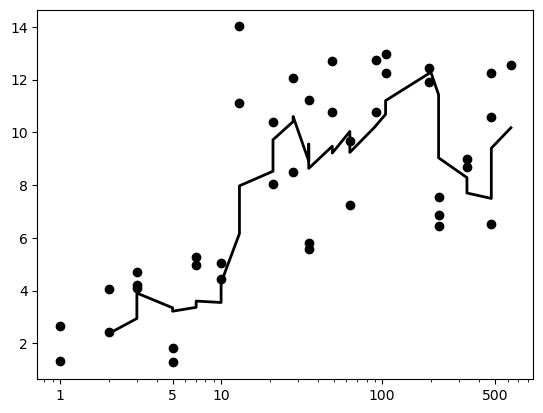

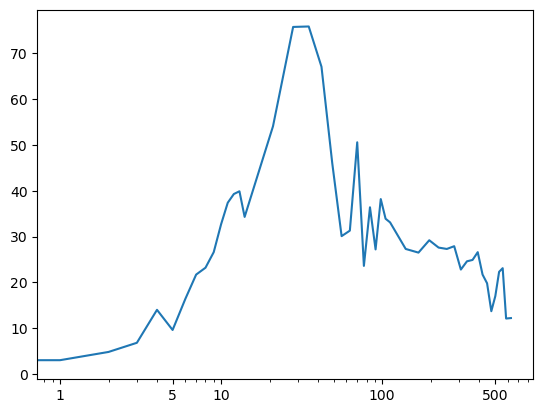

PearsonRResult(statistic=0.7029934243304873, pvalue=1.4713310449021416e-07)


In [35]:
# Create a scatter plot and rolling average of the ratio of medulla points to points in the perimeter over time
fig, ax = plt.subplots()
time = [batch_to_tpt[i] for i in batch_plot]
ratio_medulla_perim = [i / j for i, j in zip(num_medulla, num_perim)]
window_size = 5
plt.scatter(time, ratio_medulla_perim, c='black')

# Calculate the rolling average using a convolution operation
rolling_avg = np.convolve(ratio_medulla_perim, np.ones(window_size) / window_size, mode='valid')
plt.plot(time[window_size - 1:], rolling_avg, label="Rolling Average", linewidth=2, c='black')

# Set x-axis scale to logarithmic and format ticks
ax.set_xscale('log', base=10)
ax.set_xticks([1, 5, 10, 100, 500])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# Save the plot
plt.savefig('cortex_medulla_ratio_age.pdf')
plt.show()

# Create a plot of weights over time
fig, ax = plt.subplots()
plt.plot(day_to_weight.keys(), day_to_weight.values())

# Set x-axis scale to logarithmic and format ticks
ax.set_xscale('log', base=10)
ax.set_xticks([1, 5, 10, 100, 500])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# Save the plot
plt.savefig('weights.pdf')
plt.show()

# Print the Pearson correlation coefficient and p-value between log-transformed time and the ratio
print(scipy.stats.pearsonr(np.log10([i + 1 for i in time]), ratio_medulla_perim))


## Figure 1E

In [36]:
# Run parallelized jobs on all replicates to perform permutation testing
region_type = 'both'  # This test only looks at interactions in this region

max_pool = 8

all_samples = []

# Iterate through puck_names to create a list of samples for which permutation testing is required
for s in puck_names:
    if region_type == 'medulla':
        # Exclude specific samples with not enough cells for medulla region
        if s in ['2022-11-23_Puck_221024_34', '2023-01-24_Puck_221103_09', '2023-01-24_Puck_221103_12']:
            continue
    
    fn = f'{directory}zscore_{s}_pd_{region_type}.pkl'
    
    if not os.path.exists(fn):
        all_samples.append([s, region_type, directory])

print(len(all_samples), 'samples left')

# Run permutation testing in parallel using multiprocessing.Pool
with Pool(max_pool) as p:
    # Use tqdm for tracking progress in the console
    pool_outputs = list(tqdm(p.imap(perm_test_to_final_plot, all_samples), total=len(all_samples)))


0 samples left


0it [00:00, ?it/s]


In [ ]:
csv_name_to_puck_name = {}
puck_to_time = {}

# Iterate through rows in master_df to create mappings for CSV names to puck names and puck names to time
for index, row in master_df.iterrows():
    puck_name = row['NovaSeq alignment directory']
    age = row['Sample Age']
    if row['Analysis Type'] != 'Mouse_aging':
        continue

    csv_name = f'{puck_name[11:25]}_B.csv'

    csv_name_to_puck_name[csv_name] = puck_name
    puck_to_time[puck_name] = age

# Create a reverse mapping of time to puck
time_to_puck = {puck_to_time[i]: i for i in puck_to_time}

# Define timepoints and create a list of puck names
timepoints = ['0 day', '1 day', '2 day', '3 day', '4 day', '5 day', '7 day', '10 day', '13 day',
              '3wks', '4 wks', '5 wks', '7wks', '9 wks', '13 wks',
              '15wks', '28wks', '32wks', '48 wks', '68 wks', '90wks']
puck_names = list(puck_to_time.keys())

# Iterate through puck_names to load z-score data for permutation testing
for s in tqdm(tqdm(puck_names)):
    if region_type == 'medulla':
        # Exclude specific samples with not enough cells for medulla region
        if s in ['2022-11-23_Puck_221024_34', '2023-01-24_Puck_221103_09', '2023-01-24_Puck_221103_12']:
            continue
    fn = f'{directory}zscore_{s}_pd_{region_type}.pkl'
    with open(fn, 'rb') as f:
        z_score_df = pkl.load(f)


100%|██████████| 47/47 [00:00<00:00, 2138.63it/s]


In [ ]:
# for each ct-ct pair
# make a vector of p values for the timepoints
all_cell_type_pairs = {}
arr_all = {}
for i in range(len(puck_names)):
    tpt = puck_to_time[puck_names[i]]
    pn = puck_names[i]
    
    #fn = open(f'prox_arr_{pn}_pd.pkl','rb')
    try:
        fn = open(f'{directory}zscore_{pn}_pd_{region_type}.pkl','rb')
    except:
        print(f'{tpt} {pn} is missing')
        continue
    print(pn)
    df = pkl.load(fn)
    arr_all[tpt] = df
    
    ct1 = df.columns # need to double check columns and rows
    ct2 = df.index
    arr = np.array(df)
    
    for i in range(len(ct1)):
        for j in range(len(ct2)):
            c1 = ct1[i]
            c2 = ct2[j]
            
            if (c1,c2) not in all_cell_type_pairs:
                all_cell_type_pairs[(c1,c2)] = []
            all_cell_type_pairs[(c1,c2)].append((tpt,arr[i][j]))

2023-01-24_Puck_220930_18
2023-01-24_Puck_220930_20
2023-01-24_Puck_220930_22
2023-01-24_Puck_220930_23
2023-01-24_Puck_220930_28
2022-12-16_Puck_220930_29_trunc
2022-11-04_Puck_220930_32
2023-01-24_Puck_220930_35
2022-12-16_Puck_220930_37_trunc
2022-12-16_Puck_220930_38_trunc
2022-12-16_Puck_221006_22_trunc
2023-01-24_Puck_221006_23
2022-11-04_Puck_221006_24
2022-12-16_Puck_221006_26_trunc
2022-12-16_Puck_221006_35_trunc
2022-11-04_Puck_221006_29
2023-01-24_Puck_221006_32
2023-01-24_Puck_221011_12
2023-01-24_Puck_221011_13
2022-12-16_Puck_221011_19_trunc
2022-12-16_Puck_221011_20_trunc
2022-12-16_Puck_221011_32_trunc
2022-12-16_Puck_221011_33_trunc
2023-01-24_Puck_221011_37
2023-01-24_Puck_221011_39
2023-01-24_Puck_221014_37
2023-01-24_Puck_221019_03
2023-01-24_Puck_221019_05
2023-01-24_Puck_221019_08
2023-01-24_Puck_221019_10
2023-01-24_Puck_221019_14
2023-01-24_Puck_221024_23
2022-11-23_Puck_221024_24
2023-01-16_Puck_221024_27
2022-11-23_Puck_221024_31
2023-01-24_Puck_221024_33
2022

 26%|██▌       | 7/27 [00:00<00:00, 68.01it/s]

CD4+T and CD4+T-1
not significant: ('DN(Q)', 'DN(Q)-1')
gdT and gdT-1
not significant: ('Treg', 'Treg-1')
DC2 and DC2-1
DP(P) and DP(P)-1
not significant: ('Mono', 'Mono-1')
not significant: ('NK', 'NK-1')
TEC_early and TEC_early-1
not significant: ('HSC', 'HSC-1')
B and B-1
Mac and Mac-1
CD8+T and CD8+T-1
alpha_beta_T(entry) and alpha_beta_T(entry)-1


100%|██████████| 27/27 [00:00<00:00, 91.69it/s]


Ery and Ery-1
not significant: ('IELpA', 'IELpA-1')
not significant: ('VSMC', 'VSMC-1')
not significant: ('IELpB_NKT', 'IELpB_NKT-1')
not significant: ('pDC', 'pDC-1')
not significant: ('Fb', 'Fb-1')
not significant: ('DP(Q)', 'DP(Q)-1')
not significant: ('DN(P)', 'DN(P)-1')
not significant: ('Endo', 'Endo-1')
not significant: ('cTEC', 'cTEC-1')
not significant: ('DC1', 'DC1-1')
not significant: ('Epi_unknown', 'Epi_unknown-1')
not significant: ('mTEC', 'mTEC-1')


Text(0.5, 80.72222222222243, 'timepoints, log+1')

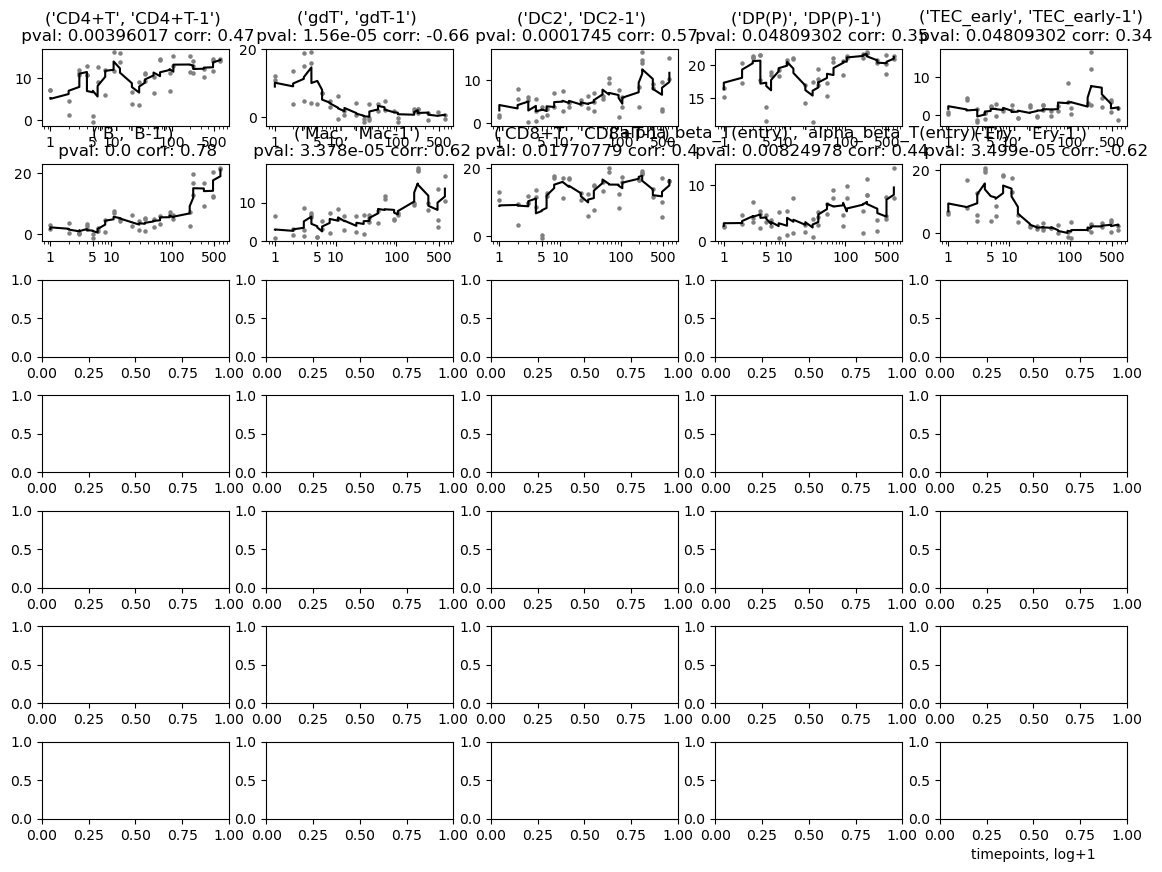

In [49]:
line_plots = {}

for i in tqdm(all_cell_type_pairs):
    # Only look at self interactions
    if i[1] != i[0] + '-1':
        if i[0] != i[1] + '-1':
            continue
    num_pairs = len(all_cell_type_pairs[i])
#     if num_pairs !=17:
#         continue
    line_plots[i] = all_cell_type_pairs[i]
        
# x_vals = [1, 3, 5, 7, 10, 13, 21, 35, 49, 63, 7*13, 7*15, 7*28, 7*32, 7*48, 7*68, 7*90]

########################################################################################
########################################################################################
########################################################################################
########################################################################################


corr_pval = True
color = 'gray'
# For calculating and correcting all p values
pval_recorder_for_corr = []
plt_cter = 0
for i in line_plots:
    if len(line_plots[i]) <= 1:
        continue
    line_plots_filt = [j for j in line_plots[i] if ~np.isnan(j[1])]
    y_vals = [j[1] for j in line_plots_filt]
    x_vals = [tpt_to_day[j[0]] for j in line_plots_filt]
    x_vals = [i+1 for i in x_vals]
    x_vals, y_vals = zip(*sorted([(i,j) for i,j in zip(x_vals,y_vals)]))
    x_vals, y_vals = zip(*sorted([(i,j) for i,j in zip(x_vals,y_vals) if np.isfinite(j)]))
    
    if len(x_vals) < 5:
        continue
    corr, pval = scipy.stats.pearsonr(np.log10(x_vals),y_vals)

    pval_recorder_for_corr.append(pval)

corr_list = stats.multitest.multipletests(pval_recorder_for_corr,method = 'fdr_bh')
corr_dict = {i:j for i,j in zip(pval_recorder_for_corr,corr_list[1])}

# For plotting
dotplot_sig_interactions = []
dotplot_sig_corr = []
dotplot_sig_pval = []

fig,axs = plt.subplots(nrows=7,ncols=5,figsize=(14,10))
plt.subplots_adjust(hspace=0.5)
pval_recorder_for_corr = []
plt_cter = 0
for i in tqdm(line_plots):
    if len(line_plots[i]) <= 1:
        print(f'only one time point: {i}')
        continue
    line_plots_filt = [j for j in line_plots[i] if ~np.isnan(j[1])]
    y_vals = [j[1] for j in line_plots[i]]
    x_vals = [tpt_to_day[j[0]] for j in line_plots[i]]
    x_vals = [i+1 for i in x_vals]
    x_vals, y_vals = zip(*sorted([(i,j) for i,j in zip(x_vals,y_vals) if np.isfinite(j)]))
    if len(x_vals) < 5:
        print(f'less than five values: {i}')
        continue
    corr, pval = scipy.stats.pearsonr(np.log10(x_vals),y_vals)
   #     stat,pval = scipy.stats.ttest_ind(old_tpt,young_tpt) ##### Calculate p val based on old vs young ttest
    if corr_pval:
        pval = corr_dict[pval]
    #print(pval)
    dotplot_sig_interactions.append(i)
    dotplot_sig_corr.append(corr)
    dotplot_sig_pval.append(pval)
    
    if (pval <0.05):
        y_vals_df = pd.DataFrame.from_dict({'y':y_vals})
        y_vals_line =y_vals_df['y'].rolling(window=5,min_periods=1,center = True).mean()
        alpha_val =1
        print(f'{i[0]} and {i[1]}')
        ax_val = axs.ravel()[plt_cter]
        plt_cter += 1
        ax_val.scatter(x_vals,y_vals,c=color,alpha = alpha_val,s=5)
        ax_val.plot(x_vals,y_vals_line,c='black',alpha = alpha_val)
        
        ax_val.set_title(str(i)+' \n pval: '+str(round(pval,8)) + ' corr: '+str(round(corr,2)))
        ax_val.set_xscale('log',base=10)
        ax_val.set_xticks([1, 5,10,100,500])
        ax_val.get_xaxis().set_major_formatter(ScalarFormatter())
        
   
    else:
        color = 'gray'
        alpha_val = 0.01
        print(f'not significant: {i}')
        continue


plt.savefig(f'Indiv_interac_{region_type}.pdf')

# plt.ylabel('z-scored interaction')
plt.xlabel('timepoints, log+1')

## S2A

In [7]:
with open(f'{directory}thymuscombined_raw_cortex_medulla.h5ad',"rb") as handle:
    adata_cm = sc.read_h5ad(handle)
    
with open(f'{directory}thymuscombined_xy.h5ad',"rb") as handle:
    adata = sc.read_h5ad(handle)

  0%|          | 0/47 [00:00<?, ?it/s]

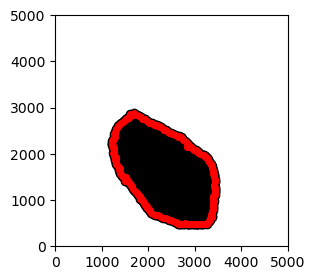

  2%|▏         | 1/47 [00:25<19:41, 25.68s/it]

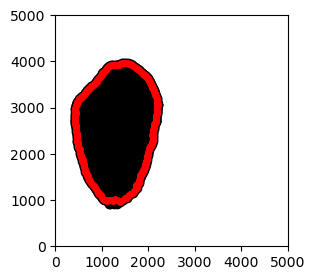

  4%|▍         | 2/47 [01:01<23:52, 31.82s/it]

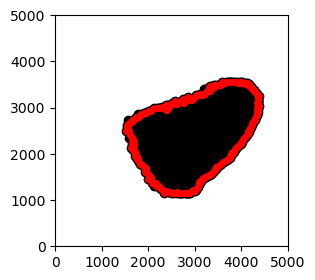

  6%|▋         | 3/47 [01:26<21:01, 28.66s/it]

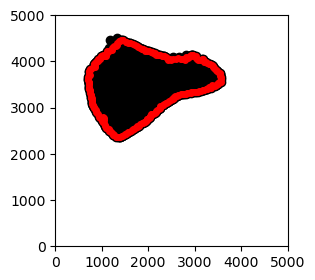

  9%|▊         | 4/47 [01:48<18:43, 26.13s/it]

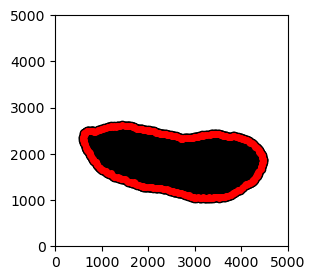

 11%|█         | 5/47 [02:41<24:59, 35.70s/it]

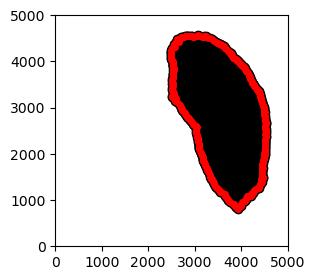

 13%|█▎        | 6/47 [03:34<28:27, 41.64s/it]

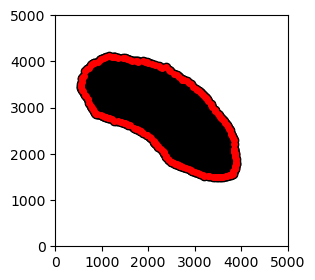

 15%|█▍        | 7/47 [04:12<26:56, 40.41s/it]

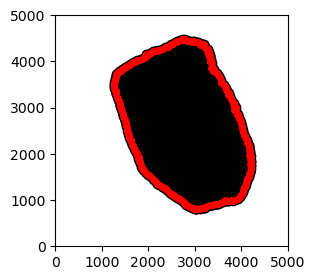

 17%|█▋        | 8/47 [06:07<41:38, 64.06s/it]

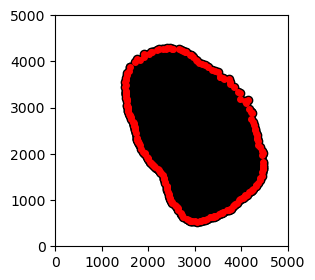

 19%|█▉        | 9/47 [07:14<41:11, 65.03s/it]

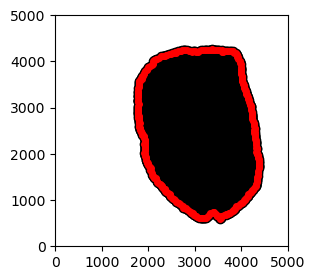

 21%|██▏       | 10/47 [08:59<47:46, 77.46s/it]

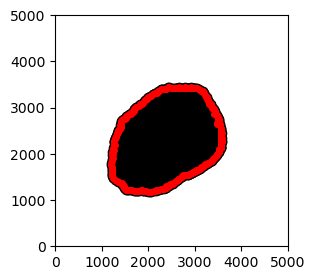

 23%|██▎       | 11/47 [09:40<39:42, 66.17s/it]

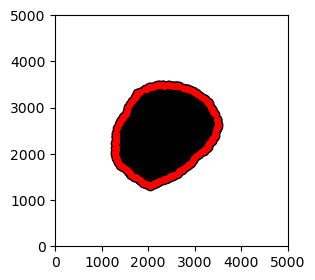

 26%|██▌       | 12/47 [10:09<31:58, 54.80s/it]

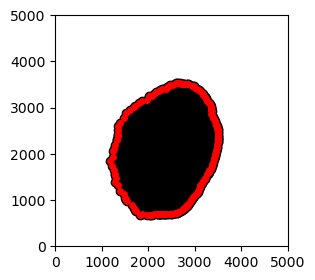

 28%|██▊       | 13/47 [10:59<30:16, 53.43s/it]

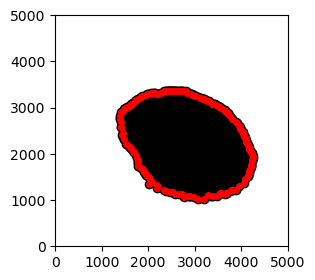

 30%|██▉       | 14/47 [11:40<27:23, 49.80s/it]

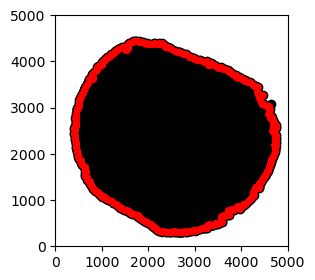

 32%|███▏      | 15/47 [15:26<54:51, 102.85s/it]

In [ ]:
# Identify pucks that have captured the entire tissue and boundary and calculate boundary distances
distances_by_batches = {}

for b in tqdm(set(adata_cm.obs.Batch)):
    adata_filt = adata_cm[adata_cm.obs.Batch == b]
    all_x = adata_filt.obs.x
    all_y = adata_filt.obs.y
    adata_filt = adata_filt[adata_filt.obs.cortex_medulla.isin(['cortex','medulla'])]

    x = [float(i) for i in adata_filt.obs.x]
    y = [float(i) for i in adata_filt.obs.y]
    
    clustered_points = list(zip(x, y))
    
    try:
        # Extract DP(P) points
        ct_filt = adata[adata.obs.Batch == float(b+1)]
        dpp_filt = ct_filt[ct_filt.obs.Cell_type == 'DP(P)']
        dpp_points = set(list(zip(dpp_filt.obs.x_val, dpp_filt.obs.y_val)))
        dpp_points = [i for i in dpp_points if i in set(clustered_points)]
        
        # Calculate distances to the boundary
        alpha_shape, distances_dpp, boundary = calculate_distance_to_boundary(clustered_points, dpp_points, show_plot=True)

        # Extract DP(Q) points
        dpq_filt = ct_filt[ct_filt.obs.Cell_type == 'DP(Q)']
        dpq_points = set(list(zip(dpq_filt.obs.x_val, dpq_filt.obs.y_val)))
        dpq_points = [i for i in dpq_points if i in set(clustered_points)]
        
        # Calculate distances to the boundary
        alpha_shape, distances_dpq, boundary = calculate_distance_to_boundary(clustered_points, dpq_points)

        distances_by_batches[b] = [distances_dpp, distances_dpq]

    except:
        try:
            # Retry with different alpha values
            alpha_shape, distances_dpp, boundary = calculate_distance_to_boundary(clustered_points, dpp_points, 
                                                                                  alpha=0.01, show_plot=True)

            alpha_shape, distances_dpq, boundary = calculate_distance_to_boundary(clustered_points, dpq_points,
                                                                                  alpha=0.01)

            distances_by_batches[b] = [distances_dpp, distances_dpq]

        except:
            try:
                # Retry with alpha = 0
                alpha_shape, distances_dpp, boundary = calculate_distance_to_boundary(clustered_points, dpp_points, 
                                                                                      alpha=0, show_plot=True)

                alpha_shape, distances_dpq, boundary = calculate_distance_to_boundary(clustered_points, dpq_points,
                                                                                      alpha=0)

                distances_by_batches[b] = [distances_dpp, distances_dpq]
              
            except:
                print(f'This batch failed three times: {b}. I give up!')


In [ ]:
plot_df = {'b':[], 'stat':[], 'type':[]}
for b in tqdm(distances_by_batches):
    dpp = distances_by_batches[b][0]
    dpq = distances_by_batches[b][1]
    plt.figure(figsize=(4,2))
    max_val = 2000#max(max(dpp), max(dpq))
    min_val = 0#min(min(dpp), min(dpq))
    plt.hist(dpp, alpha = 0.5,range = (min_val, max_val), bins=20, density = True, label = 'dpp')
    plt.hist(dpq, alpha = 0.5, range = (min_val, max_val), bins = 20, density = True, label = 'dpq')
    plt.title(b)

    plt.legend()
    plt.savefig('distance_comparison.pdf')
    plt.show()
    stat,pval = scipy.stats.kstest(dpp, dpq)
    print(stat,pval)
    plot_df['b'].append(b)
    plot_df['stat'].append(stat)
    if batch_to_tpt[b] <= 35:
        plot_df['type'].append('young')
    else:
        plot_df['type'].append('old')

In [ ]:
plot_df = pd.DataFrame.from_dict(plot_df)

from scipy.stats import ks_2samp
df = copy.deepcopy(plot_df)

# Separate KS test statistics for young and old types
ks_young = df.loc[df['type'] == 'young', 'stat']
ks_old = df.loc[df['type'] == 'old', 'stat']

# Observed KS test statistic
observed_ks_statistic, _ = ks_2samp(ks_young, ks_old)

# Number of permutations
num_permutations = 1000

# Concatenate the KS test statistics
all_ks = np.concatenate([ks_young, ks_old])

# Initialize an array to store permuted test statistics
permuted_ks_statistics = np.zeros(num_permutations)

# Permutation test
for i in range(num_permutations):
    # Shuffle the combined data
    np.random.shuffle(all_ks)

    # Split the shuffled data into two groups
    shuffled_ks_young = all_ks[:len(ks_young)]
    shuffled_ks_old = all_ks[len(ks_young):]

    # Calculate KS test statistic for the shuffled data
    permuted_ks_statistic, _ = ks_2samp(shuffled_ks_young, shuffled_ks_old)

    # Store the permuted test statistic
    permuted_ks_statistics[i] = permuted_ks_statistic

# Calculate p-value
p_value = (np.sum(permuted_ks_statistics >= observed_ks_statistic) + 1) / (num_permutations + 1)


In [ ]:
print(p_value)

In [ ]:

sns.barplot(plot_df, x = 'type',y = 'stat', errorbar = 'se')
plt.savefig('dpq_dpp_diff.pdf')

In [ ]:
import geopandas as gpd
from libpysal.weights import KNN
from esda.moran import Moran
import numpy as np
from shapely.geometry import Point


def calculate_morans_i(x,y,label,label_of_interest):
    # Create a GeoDataFrame
    geometry = [Point(xy) for xy in zip(x, y)]
    gdf = gpd.GeoDataFrame({'x': x, 'y': y, 'label': label}, geometry = geometry)

    # Create spatial weights matrix using K-nearest neighbors
    k = 5  # You can adjust the number of neighbors (k) as needed
    w = KNN.from_dataframe(gdf, k=k)

    # Calculate Moran's I for subset
    moran_ct1 = Moran(gdf['label'].apply(lambda x: 1 if x == label_of_interest else 0), w)

    # Print the Moran's I statistics
    print(f"Moran's I for {label_of_interest} Points:")
    print("I:", moran_ct1.I)
    print("Expected I:", moran_ct1.EI)
    print("p-value:", moran_ct1.p_sim)

    return moran_ct1.I

In [ ]:
def find_indices(lst, target_item):
    return [index for index, item in enumerate(lst) if item == target_item]

In [ ]:
from scipy.spatial import cKDTree

mi_all = []
adata_filt_cts = adata[adata.obs.Cell_type.isin(['DP(P)','DP(Q)'])]

all_neighbor_frac = []
for b in tqdm(set(adata.obs.Batch)):
    adata_filt = adata_filt_cts[adata_filt_cts.obs.Batch == b]
    
    x = list(adata_filt.obs.x_val)
    y = list(adata_filt.obs.y_val)
    label = list(adata_filt.obs.Cell_type)
    if len(label) < 100:
        continue
    # test = calculate_morans_i(x,y,label,'DP(P)')
    # print(test)
    # mi_all.append(test)
    pts = list(zip(x,y))
    pts_ct1 = [pts[idx] for idx in find_indices(label,'DP(Q)')]#DP(P)
    if len(pts_ct1) < 100:
        continue
    kdtree = cKDTree(pts)
    neighbor_frac = []
    for pt in pts_ct1:
        distance, indices = kdtree.query(pt,20) # pick 100 nearby pts
        nearby_pts = [pts[idx] for idx in indices]
        nearby_labels = [label[idx] for idx in indices]
        cter = Counter(nearby_labels)
        neighbor_frac.append(cter['DP(P)']/sum(cter.values()))
    
#     plt.figure(figsize=(3,0.5))
#     plt.hist(neighbor_frac)
#     plt.show()
    all_neighbor_frac.append(neighbor_frac)

In [ ]:
items = [np.mean(i) for i in all_neighbor_frac]

In [ ]:
fig,ax = plt.subplots()
plt.scatter(puck_times,items)


ax.set_xscale('log',base=10)
ax.set_xticks([20,100,500])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    
    
scipy.stats.ttest_ind(np.log10([i+1 for i in puck_times]),items)



In [ ]:
line_plots = {}

for i in tqdm(all_cell_type_pairs):
    # Only look at self interactions
    if i[0] not in ['DP(P)','DP(Q)','DN(P)','DN(Q)']:
        continue
    if i[1] not in ['DP(P)-1','DP(Q)-1','DN(P)-1','DN(Q)-1']:
        continue
    line_plots[i] = all_cell_type_pairs[i]
        
# x_vals = [1, 3, 5, 7, 10, 13, 21, 35, 49, 63, 7*13, 7*15, 7*28, 7*32, 7*48, 7*68, 7*90]

########################################################################################
########################################################################################
########################################################################################
########################################################################################


corr_pval = True
color = 'gray'
# For calculating and correcting all p values
pval_recorder_for_corr = []
plt_cter = 0
for i in line_plots:
    if len(line_plots[i]) <= 1:
        continue
    line_plots_filt = [j for j in line_plots[i] if ~np.isnan(j[1])]
    y_vals = [j[1] for j in line_plots_filt]
    x_vals = [tpt_to_day[j[0]] for j in line_plots_filt]
    x_vals = [i+1 for i in x_vals]
    x_vals, y_vals = zip(*sorted([(i,j) for i,j in zip(x_vals,y_vals)]))
    x_vals, y_vals = zip(*sorted([(i,j) for i,j in zip(x_vals,y_vals) if np.isfinite(j)]))
    
    if len(x_vals) < 5:
        continue
    corr, pval = scipy.stats.pearsonr(np.log10(x_vals),y_vals)

    pval_recorder_for_corr.append(pval)

corr_list = stats.multitest.multipletests(pval_recorder_for_corr,method = 'fdr_bh')
corr_dict = {i:j for i,j in zip(pval_recorder_for_corr,corr_list[1])}

# For plotting
dotplot_sig_interactions = []
dotplot_sig_corr = []
dotplot_sig_pval = []

fig,axs = plt.subplots(nrows=7,ncols=5,figsize=(14,10))
plt.subplots_adjust(hspace=0.5)
pval_recorder_for_corr = []
plt_cter = 0
for i in tqdm(line_plots):
    if len(line_plots[i]) <= 1:
        print(f'only one time point: {i}')
        continue
    line_plots_filt = [j for j in line_plots[i] if ~np.isnan(j[1])]
    y_vals = [j[1] for j in line_plots[i]]
    x_vals = [tpt_to_day[j[0]] for j in line_plots[i]]
    x_vals = [i+1 for i in x_vals]
    x_vals, y_vals = zip(*sorted([(i,j) for i,j in zip(x_vals,y_vals) if np.isfinite(j)]))
    if len(x_vals) < 5:
        print(f'less than five values: {i}')
        continue
    corr, pval = scipy.stats.pearsonr(np.log10(x_vals),y_vals)
   #     stat,pval = scipy.stats.ttest_ind(old_tpt,young_tpt) ##### Calculate p val based on old vs young ttest
    if corr_pval:
        pval = corr_dict[pval]
    #print(pval)
    dotplot_sig_interactions.append(i)
    dotplot_sig_corr.append(corr)
    dotplot_sig_pval.append(pval)
    
    if (pval <0.05):
        y_vals_df = pd.DataFrame.from_dict({'y':y_vals})
        y_vals_line =y_vals_df['y'].rolling(window=5,min_periods=1,center = True).mean()
        alpha_val =1
        print(f'{i[0]} and {i[1]}')
        ax_val = axs.ravel()[plt_cter]
        plt_cter += 1
        ax_val.scatter(x_vals,y_vals,c=color,alpha = alpha_val,s=5)
        ax_val.plot(x_vals,y_vals_line,c='black',alpha = alpha_val)
        
        ax_val.set_title(str(i)+' \n pval: '+str(round(pval,8)) + ' corr: '+str(round(corr,2)))
        ax_val.set_xscale('log',base=10)
        ax_val.set_xticks([1, 5,10,100,500])
        ax_val.get_xaxis().set_major_formatter(ScalarFormatter())
        
   
    else:
        color = 'gray'
        alpha_val = 0.01
        print(f'not significant: {i}')
        continue


plt.savefig(f'Indiv_interac_{region_type}.pdf')

# plt.ylabel('z-scored interaction')
plt.xlabel('timepoints, log+1')


########################################################################################
########################################################################################
########################################################################################
########################################################################################

fig,ax = plt.subplots(figsize=(10,5))
for i in tqdm(line_plots):
    if len(line_plots[i]) <= 1:
        continue
    
    y_vals = [j[1] for j in line_plots[i]]
    x_vals = [tpt_to_day[j[0]] for j in line_plots[i]]
    x_vals = [i+1 for i in x_vals]
    x_vals, y_vals = zip(*sorted([(i,j) for i,j in zip(x_vals,y_vals)]))
    if not all(np.isfinite(y_vals)):
        continue
    corr, pval = scipy.stats.pearsonr(np.log10(x_vals),y_vals)
    pval = corr_dict[pval]
    #print(pval)
    if (pval <0.05):
        color = 'red'
        alpha_val =1
        print(f'{i[0]} and {i[1]} pval: {pval} corr: {corr}')
    else:
        color = 'gray'
        alpha_val = 0.01
    plt.plot(x_vals,y_vals,c=color,alpha = alpha_val)
    ax.set_title(str(i)+' \n pval: '+str(round(pval,8)) + ' corr: '+str(round(corr,2)))
    ax.set_xscale('log',base=10)
    ax.set_xticks([1, 5,10,100,500])
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
plt.ylabel('1 = low interaction, 0 = high interaction')
plt.xlabel('timepoints')
plt.ylim([-30,30])
fn_to_save = f'interactions_{region_type}_all.pdf'
plt.savefig(fn_to_save)
!gsutil cp ./$fn_to_save gs://fc-secure-2423a594-f5fe-40c6-b998-f28ac17ea012
      